In [2]:
import shutil
import os
import tarfile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
import time
import math
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import log_loss, confusion_matrix, plot_confusion_matrix
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D,Conv2D,Dropout,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.datasets import load_files
import cv2
import pickle
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels



In [3]:
train_label = pd.read_csv('../data/dataset/train.csv')
test_label = pd.read_csv('../data/dataset/test.csv')
 

In [4]:
Y=train_label
total = len(Y)
ax=sns.countplot(x=Y.label, data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.2, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 10))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.2f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.title('Distribution of classes in training data')
plt.show()

In [5]:
test_label.label.value_counts()

ЗУ                 150
БТИ                 69
Разр. на ввод       56
Свид. АГР           32
Разр. на стр-во     27
Name: label, dtype: int64

In [6]:
train_dir = '../data/dataset/train'
test_dir = '../data/dataset/test'

label_to_classes = {
    'БТИ': 0,
    'ЗУ': 1,
    'Разр. на ввод': 2,
    'Свид. АГР': 3,
    'Разр. на стр-во': 4,
}

classes_to_label = {value: key for key, value in label_to_classes.items()}

In [57]:
classes_to_label

{0: 'БТИ', 1: 'ЗУ', 2: 'Разр. на ввод', 3: 'Свид. АГР', 4: 'Разр. на стр-во'}

In [30]:
img_width, img_height = 512, 512
nb_train_samples = 1500
nb_validation_samples = 350 
batch_size = 50
epochs = 20
num_classes=5
log=[]



In [31]:
train_datagen = ImageDataGenerator(rescale = 1./255, featurewise_std_normalization=True)

test_datagen = ImageDataGenerator(rescale = 1./255, featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (img_height, img_width), 
    batch_size = batch_size, 
    class_mode = "categorical")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical"
)

Found 1332 images belonging to 5 classes.
Found 334 images belonging to 5 classes.


In [32]:
x, y = test_generator.next()

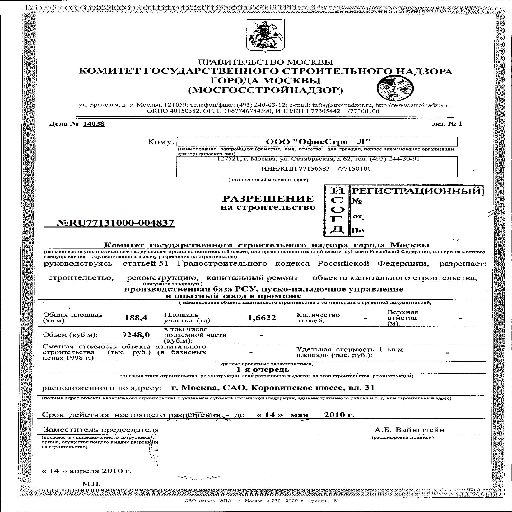

In [55]:
import random
from PIL import Image
i = random.choice(range(len(x)))
img = Image.fromarray((x[i] * 255).astype(np.uint8))

img.resize((512,512))

In [59]:
y[i]

array([0., 0., 0., 1., 0.], dtype=float32)

In [58]:
test_generator.filenames[i]

'БТИ/12. Поликарпова ул.,д.2, корп.10+ исп/11.png'

In [ ]:
import matplotlib.pyplot as plt
import os
n = 7
x,y = test_generator.next()
for i in range(0,n):
    plt.figure(figsize=(2, 2))
    image_x = x[i,:,:,0]
    image_label = os.path.dirname(test_generator.filenames[i]) # only OK if shuffle=false
    print(image_label)
    plt.imshow(image_x)
    plt.show()


In [125]:
# Importing keras InceptionRsnetv2 pretrained model (on ImageNet)
# We will use the ImageNet weight to initialize the model and fine tune using backpropagation(Transfer Learning) 
from keras import regularizers
model=applications.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
for layer in model.layers[:25]:
   layer.trainable = False
#Adding custom Layers 
x = model.output
x=Dropout(0.5)(x)
x = Flatten()(x)
output = Dense(num_classes, activation="softmax")(x)
model = Model(model.inputs, outputs = output)
model.summary()
# model.compile()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2639 (Conv2D)            (None, 111, 111, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2639 (Batch (None, 111, 111, 32) 96          conv2d_2639[0][0]                
__________________________________________________________________________________________________
activation_2639 (Activation)    (None, 111, 111, 32) 0           batch_normalization_2639[0][0]   
______________________________________________________________________________________

In [127]:
# Training for 10 epochs
from keras.callbacks import ReduceLROnPlateau
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
checkpoint = ModelCheckpoint("inceptionresnet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001,mode='auto')
callbacks=[checkpoint,reduce_lr]

history=model.fit(
    train_generator,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = test_generator.samples/test_generator.batch_size,
    callbacks = callbacks,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    verbose=1
)
log.append(history)


Epoch 1/10
27/26 [==============================] - 219s 8s/step - loss: 0.8684 - accuracy: 0.8018 - val_loss: 55.6028 - val_accuracy: 0.3653
Epoch 2/10
27/26 [==============================] - 215s 8s/step - loss: 0.0877 - accuracy: 0.9662 - val_loss: 1.1706 - val_accuracy: 0.7275
Epoch 3/10
27/26 [==============================] - 215s 8s/step - loss: 0.0382 - accuracy: 0.9887 - val_loss: 2.0249 - val_accuracy: 0.5389
Epoch 4/10
27/26 [==============================] - 215s 8s/step - loss: 0.0488 - accuracy: 0.9872 - val_loss: 0.7104 - val_accuracy: 0.9162
Epoch 5/10
27/26 [==============================] - 214s 8s/step - loss: 0.1323 - accuracy: 0.9625 - val_loss: 120.5341 - val_accuracy: 0.5120
Epoch 6/10
27/26 [==============================] - 215s 8s/step - loss: 0.1454 - accuracy: 0.9617 - val_loss: 144.9676 - val_accuracy: 0.4461
Epoch 7/10
27/26 [==============================] - 214s 8s/step - loss: 0.0740 - accuracy: 0.9760 - val_loss: 44.3534 - val_accuracy: 0.5479
Epoch 8

In [129]:
model.save('resinception_acc97.h5')

In [166]:
from keras.models import load_model
#!cp 'drive/My Drive/vgg16_85.h5' 'vgg16_85.h5'
#!cp 'drive/My Drive/resinception_85.h5' 'Inception_resnet.h5'
model1=load_model('resinception_acc97.h5')

In [167]:
model1.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2639 (Conv2D)            (None, 111, 111, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2639 (Batch (None, 111, 111, 32) 96          conv2d_2639[0][0]                
__________________________________________________________________________________________________
activation_2639 (Activation)    (None, 111, 111, 32) 0           batch_normalization_2639[0][0]   
______________________________________________________________________________________

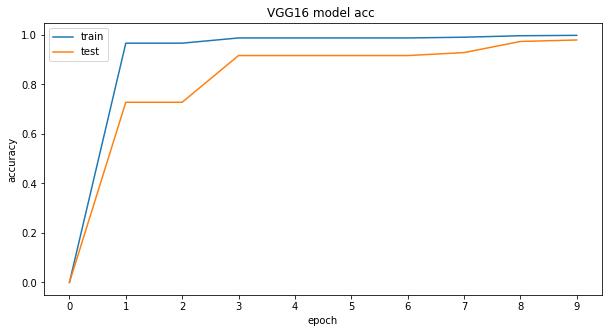

In [147]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 model acc ')
plt.ylabel('accuracy')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('vgg16_acc.png')



In [163]:
from statistics import mode
from sklearn.utils.multiclass import unique_labels
def eval_model(model,test_generator,limit):
    """
    This function creates an ensamble of candidate CNN models and predict the result
    model1,model2 -- candidate models
    test_generator -- Instance of ItemDataGenerator to randomly generate test data
    limit -- limits the number of test samples
    
    """
    count=0
    y_pred=[]
    y_true=[]
    while count <= limit:
        x,y=test_generator.next()
        for i in range(len(x)):
            pred=model.predict(np.expand_dims(x[i], axis=0))
            y_pred.append(np.argmax(pred))
            y_true.append(np.argmax(y[i]))
            count+=1
    return y_pred,y_true

def get_result(y_pred,y_true):
    """
    This function evaluate the performance(accuracy,f1-score,precision,recall,confusion matrix of the network).
    """
    print('-----Model Evaluation------')
    accuracy=np.round(accuracy_score(y_pred,y_true),3)
    f1=np.round(f1_score(y_pred,y_true,average='macro'),3)
    precision=np.round(precision_score(y_pred,y_true,average='macro'),3)
    recall=np.round(recall_score(y_pred,y_true,average='macro'),3)
    print('Accuracy:',(accuracy)*100,'%')
    print('Macro F1 Score:',f1)
    print('Precision Score:',precision)
    print('Recall Score:',recall)
    plot_confusion_matrix(y_true,y_pred)
    return accuracy,f1,precision,recall



In [158]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3,4]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,10))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    # plt.show()
    plt.savefig('confusion_matrix.png')

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,10))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    # plt.show()
    plt.savefig('precision_matrix.png')
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,10))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    # plt.show()
    plt.savefig('recall_matrix.png')
    print("Sum of rows in precision matrix",A.sum(axis=1))



-----Model Evaluation------
Accuracy: 97.89999999999999 %
Macro F1 Score: 0.976
Precision Score: 0.97
Recall Score: 0.984
-------------------------------------------------- Confusion matrix --------------------------------------------------
-------------------------------------------------- Precision matrix --------------------------------------------------
Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------
Sum of rows in precision matrix [1. 1. 1. 1. 1.]


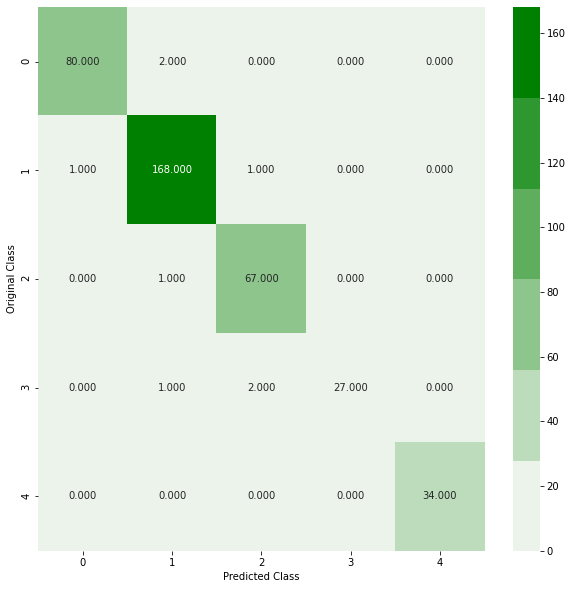

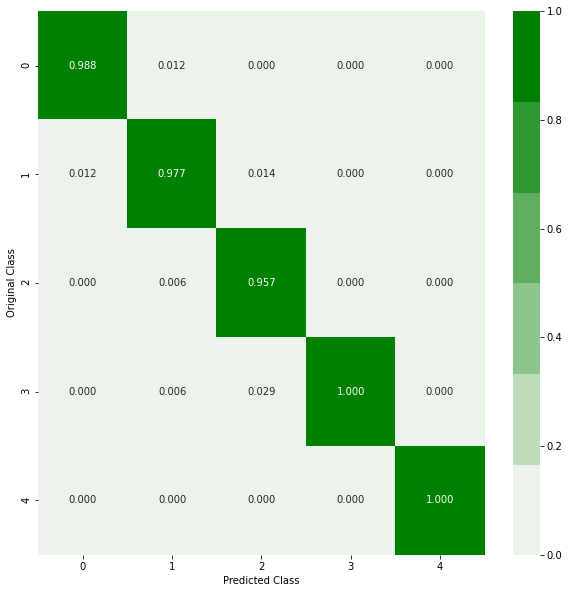

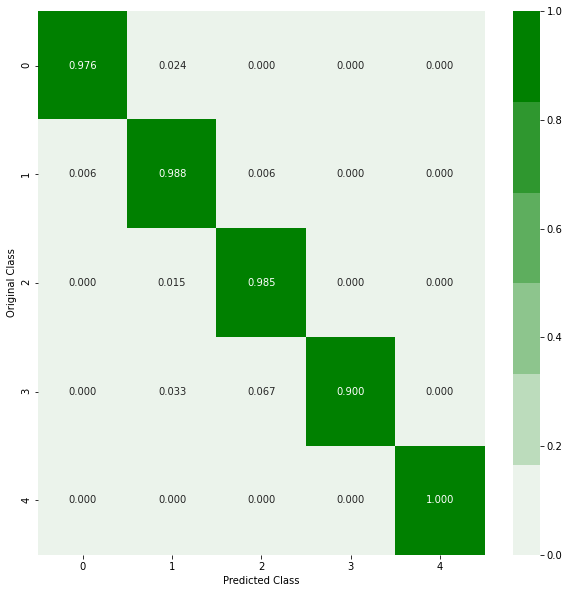

In [165]:
y_pred,y_true=eval_model(model,test_generator,350)
accuracy,f1,precision,recall=get_result(y_pred,y_true)

In [1]:
!python --version


Python 3.8.5


In [1]:
from keras.models import load_model


load_model('resinception_acc97.h5')

